In [280]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

from random import shuffle
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [283]:
dirp = Path('/Users/hq/Documents/data/hic/')
df = pd.read_table(dirp / 'dn3' / 'DN3_Interactions_20K.txt', index_col=0)
df.head()

,PeakID(1),chr(1),start(1),end(1),strand(1),Total Reads(1),PeakID(2),chr(2),start(2),end(2),strand(2),Total Reads(2),Distance,Interaction Reads,Expected Reads,Z-score,LogP,"FDR(Benjamini, based on 9.27e+09 total tests)",Circos Thickness
InteractionID,,,,,,,,,,,,,,,,,,,
interaction1,chr2-167880000,chr2,167880000,167900000,+,2156.0,chr2-167680000,chr2,167680000,167700000,+,2063.0,202961,99.0,9.034123,3.250643,-152.153328,0.0,36
interaction2,chr8-126920000,chr8,126920000,126940000,+,1752.0,chr8-126480000,chr8,126480000,126500000,+,2022.0,437007,67.0,4.119315,3.203187,-128.070505,0.0,30
interaction3,chr13-52220000,chr13,52220000,52240000,+,2166.0,chr13-51840000,chr13,51840000,51860000,+,2126.0,379749,61.0,5.155698,2.904132,-98.491389,0.0,22
interaction4,chr7-143460000,chr7,143460000,143480000,+,1798.0,chr7-143140000,chr7,143140000,143160000,+,2014.0,318487,60.0,5.349958,2.925511,-94.088732,0.0,22
interaction5,chr10-22000000,chr10,22000000,22020000,+,1386.0,chr10-21380000,chr10,21380000,21400000,+,1704.0,616781,43.0,2.024511,3.360393,-93.779751,0.0,22


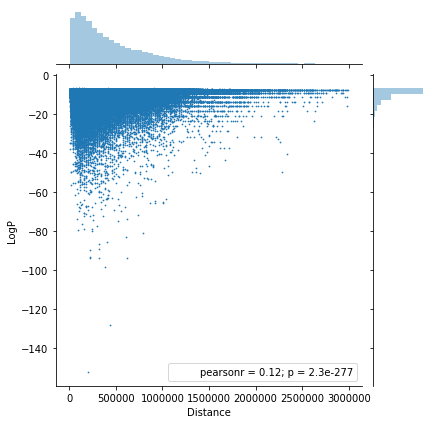

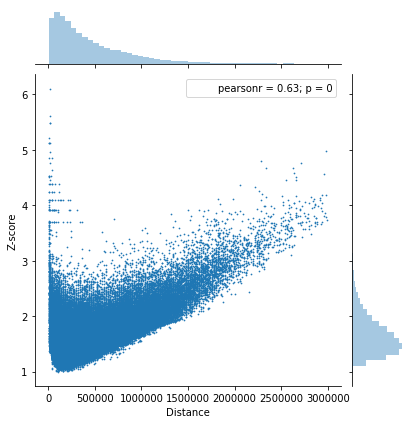

In [290]:
sns.jointplot(x='Distance', y='LogP', data=df, joint_kws={'s': 0.5})

sns.jointplot(x='Distance', y='Z-score', data=df, joint_kws={'s': 0.5})


In [212]:
# input homer significant interaction table, return intra interactions by chr

def merge_interaction(df, binsize, verbose=False, eps=0.001, min_samples=5):
    x = df['PeakID(1)'].apply(lambda i: int(i.split('-')[-1]) // binsize)
    y = df['PeakID(2)'].apply(lambda i: int(i.split('-')[-1]) // binsize)
    
    coord_df = pd.DataFrame([x, y]).T
    coord_df['chr(1)'] = df['chr(1)'].tolist()[0]
    coord_df['chr(2)'] = df['chr(2)'].tolist()[0]
    
    X = np.array(list(zip(x, y)))
    X = StandardScaler().fit_transform(X)
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    labels = db.labels_
    
    if verbose:
        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        print('Estimated number of clusters in %s vs %s: %d' % 
              (df['chr(1)'][0], df['chr(2)'][0], n_clusters_))
    
    coord_df['cluster_dbscan'] = list(map(int, labels))
    return coord_df


def merge_cluster(df):
    square_size = (df['PeakID(1)'].max() - df['PeakID(1)'].min() + 1) * \
                  (df['PeakID(2)'].max() - df['PeakID(2)'].min() + 1)
    real_interaction = df.shape[0]
    precent = real_interaction/square_size
    line = [[df['PeakID(1)'].min(), df['PeakID(1)'].max(), 
                          df['PeakID(2)'].min(), df['PeakID(2)'].max(),
                          real_interaction, square_size, precent]]
    if df['cluster_dbscan'][0] == -1:
        line = [[0, 0, 0, 0, 0, 0, 0]]
    return pd.DataFrame(line, columns=['peak1_start', 'peak1_end', 'peak2_start', 'peak2_end',
                                       'interactions', 'region_size', 'percentage'])


def merge_homer_inter_table(fp, binsize=20000, eps=0.001, min_samples=5, merge=False):
    df_list = []
    df = pd.read_table(fp, index_col=0)
    cluster = df.groupby(['chr(1)', 'chr(2)']).apply(merge_interaction, binsize=binsize,
                                                     eps=eps, min_samples=min_samples)
    if merge:
        merge = cluster.groupby(['chr(1)', 'chr(2)', 'cluster_dbscan']).apply(merge_cluster)
        merge.reset_index(inplace=True)
        merge.drop('level_3', inplace=True, axis=1)
        return merge
    else:
        return cluster

    
def merge_inter_df(df, binsize=20000, eps=0.001, min_samples=5, merge=False):
    cluster = df.groupby(['chr(1)', 'chr(2)']).apply(merge_interaction, binsize=binsize,
                                                     eps=eps, min_samples=min_samples)
    if merge:
        merge = cluster.groupby(['chr(1)', 'chr(2)', 'cluster_dbscan']).apply(merge_cluster)
        merge.reset_index(inplace=True)
        merge.drop('level_3', inplace=True, axis=1)
        return merge
    else:
        return cluster
    
    
def plot_cluster(df, chrom='chr1', region=[1000, 2000], figsize=10, outliers=False, cluster_color = True, unicolor=(0,0.5,0.5)):
    chr_df = df[df['chr(1)'] == chrom]
    
    if outliers:
        out_color = (0.7,0.7,0.7)
    else:
        out_color = (1,1,1)
    if cluster_color:
        colors = sns.color_palette("husl", int(chr_df['cluster_dbscan'].max()) + 1)
        shuffle(colors)
        color_list = chr_df['cluster_dbscan'].apply(lambda i: colors[int(i)] if i != -1 else out_color)
        scatter_df = pd.DataFrame([chr_df['PeakID(1)'], chr_df['PeakID(2)'], color_list], index=['x', 'y', 'color']).T
        r_scatter_df = pd.DataFrame([chr_df['PeakID(2)'], chr_df['PeakID(1)'], color_list], index=['x', 'y', 'color']).T
        scatter_df = pd.concat([scatter_df, r_scatter_df])
        sub_scatter_df = scatter_df[(scatter_df['x'] > region[0]) & (scatter_df['x'] < region[1]) & 
                            (scatter_df['y'] > region[0]) & (scatter_df['y'] < region[1])]
    else:
        chr_df = chr_df[chr_df['cluster_dbscan'] >= 0]
        scatter_df = pd.DataFrame([chr_df['PeakID(1)'], chr_df['PeakID(2)']], index=['x', 'y']).T
        r_scatter_df = pd.DataFrame([chr_df['PeakID(2)'], chr_df['PeakID(1)']], index=['x', 'y']).T
        scatter_df = pd.concat([scatter_df, r_scatter_df])
        sub_scatter_df = scatter_df[(scatter_df['x'] > region[0]) & (scatter_df['x'] < region[1]) & 
                            (scatter_df['y'] > region[0]) & (scatter_df['y'] < region[1])]
    fig, ax=plt.subplots()
    fig.set_size_inches(figsize, figsize)
    if cluster_color:
        ax.scatter(sub_scatter_df['x'], sub_scatter_df['y'], c=sub_scatter_df['color'], s=5, marker="s")
    else:
        ax.scatter(sub_scatter_df['x'], sub_scatter_df['y'], c=unicolor, s=5, marker="s")
    ax.set_xlim(region)
    ax.set_ylim(region)
    
    plt.show()
    return


def average_interaction(df, binsize, merge_field, ave_size=3):
    ave_size = ( ave_size // 2 ) * 2 + 1
    expend = ave_size // 2
    x = df['PeakID(1)'].apply(lambda i: int(i.split('-')[1]) // binsize)
    y = df['PeakID(2)'].apply(lambda i: int(i.split('-')[1]) // binsize)
    chrom1 = df['chr(1)'][0]
    chrom2 = df['chr(2)'][0]
    
    raw_array = np.zeros((max(x) + 2 * expend, max(y) + 2 * expend))
    for i, row in df.iterrows():
        x_row = int(row['PeakID(1)'].split('-')[1]) // binsize
        y_row = int(row['PeakID(2)'].split('-')[1]) // binsize
        raw_array[x_row + expend, y_row + expend] = row[merge_field]
    total_rows = []
    
    point_set = set()
    for pair in zip(x.tolist(), y.tolist()):
        for i in range(-expend, expend+1):
            for j in range(-expend, expend+1):
                point_set.add((pair[0]+i, pair[1]+j))
    
    for x, y in list(point_set):
        ave_region = raw_array[x : x + 2 * expend + 1, y : y + 2 * expend + 1].flatten()
        ave_value = ave_region[np.nonzero(ave_region)].mean()
        if not np.isnan(ave_value):
            total_rows.append([chrom1, chrom2, chrom1 + '-' + str(x*binsize), chrom2 + '-' + str(y*binsize), ave_value])
    return pd.DataFrame(total_rows, columns=['chr(1)', 'chr(2)', 'PeakID(1)', 'PeakID(2)', merge_field])


In [203]:
dirp = Path('/Users/hq/Documents/data/hic/')
df1 = merge_homer_inter_table(dirp / 'dn3' / 'DN3_Interactions_20K.txt', eps=0.003, min_samples=8)
df2 = merge_homer_inter_table(dirp / 'dp' / 'DP_Interactions_20K.txt', eps=0.003, min_samples=8)
df3 = merge_homer_inter_table(dirp / 'gdTCR' / 'gdT_Interactions_20K.txt', eps=0.003, min_samples=8)

plot_cluster(df1, figsize=5, region=[1900, 2000])
plot_cluster(df2, figsize=5, region=[1900, 2000])
plot_cluster(df3, figsize=5, region=[1900, 2000])

KeyboardInterrupt: 

In [122]:
dirp = Path('/Users/hq/Documents/data/hic/')
dn3_df = pd.read_table(dirp / 'dn3' / 'DN3_Interactions_20K.txt', index_col=0)
dn3_df_chr1 = dn3_df[dn3_df['chr(1)'] == 'chr1']
dn3_df_chr1_ave = average_interaction(dn3_df_chr1, 20000, merge_field='Z-score', ave_size=3)
dn3_df_chr1_ave.sort_values(['PeakID(1)', 'PeakID(2)'], inplace=True)
dn3_df_chr1_ave.set_index(['PeakID(1)', 'PeakID(2)'], inplace=True)


dp_df = pd.read_table(dirp / 'dp' / 'DP_Interactions_20K.txt', index_col=0)
dp_df_chr1 = dp_df[dp_df['chr(1)'] == 'chr1']
dp_df_chr1_ave = average_interaction(dp_df_chr1, 20000, merge_field='Z-score', ave_size=3)
dp_df_chr1_ave.sort_values(['PeakID(1)', 'PeakID(2)'], inplace=True)
dp_df_chr1_ave.set_index(['PeakID(1)', 'PeakID(2)'], inplace=True)


count    48388.000000
mean         0.005712
std          1.537557
min         -5.979370
25%         -1.494459
50%          0.000250
75%          1.468210
max          4.526561
Name: delta_zscore, dtype: float64

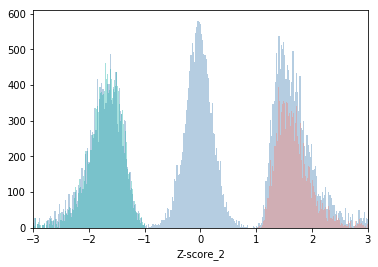

In [299]:
ax = sns.distplot(df['delta_zscore'], bins=500, kde=False, color='steelblue')
sns.distplot(df['Z-score_1'][df['Z-score_1'] > 0], bins=500, kde=False, color='salmon', ax=ax)
sns.distplot(-df['Z-score_2'][df['Z-score_2'] > 0], bins=500, kde=False, color='lightseagreen', ax=ax)
ax.set_xlim((-3, 3))

df['delta_zscore'].describe()

In [293]:
df = pd.concat([dn3_df_chr1_ave, dp_df_chr1_ave[['Z-score']]], axis=1)
df.columns = ['chr(1)', 'chr(2)', 'Z-score_1', 'Z-score_2']
df['Z-score_1'].fillna(0, inplace=True)
df['Z-score_2'].fillna(0, inplace=True)
df['chr(1)'].fillna(dn3_df_chr1_ave['chr(1)'][0], inplace=True)
df['chr(2)'].fillna(dn3_df_chr1_ave['chr(2)'][0], inplace=True)

df['delta_zscore'] = df['Z-score_1'] - df['Z-score_2']
df['condition_1_only'] = df['Z-score_2'] == 0
df['condition_2_only'] = df['Z-score_1'] == 0
df['overlap'] = (~df['condition_1_only']) & (~df['condition_2_only'])
df.reset_index(inplace=True)

print(df.shape)


(48388, 10)


In [275]:
cd1_only = df[df['condition_1_only']][['PeakID(1)', 'PeakID(2)', 'chr(1)', 'chr(2)', 'Z-score_1']]
cd1_only.columns = ['PeakID(1)', 'PeakID(2)', 'chr(1)', 'chr(2)', 'Z-score']

cd2_only = df[df['condition_2_only']][['PeakID(1)', 'PeakID(2)', 'chr(1)', 'chr(2)', 'Z-score_2']]
cd1_only.columns = ['PeakID(1)', 'PeakID(2)', 'chr(1)', 'chr(2)', 'Z-score']

cd1_positive = df[df['delta_zscore'] > 0.1][['PeakID(1)', 'PeakID(2)', 'chr(1)', 'chr(2)', 'Z-score_1']]

cd2_positive = df[df['delta_zscore'] < -0.1][['PeakID(1)', 'PeakID(2)', 'chr(1)', 'chr(2)', 'Z-score_2']]

cd2_positive.head()


,PeakID(1),PeakID(2),chr(1),chr(2),Z-score_2
4,chr1-10000000,chr1-9740000,chr1,chr1,1.772133
5,chr1-10000000,chr1-9760000,chr1,chr1,1.834828
6,chr1-10000000,chr1-9780000,chr1,chr1,1.701983
7,chr1-10000000,chr1-9800000,chr1,chr1,1.631833
10,chr1-100000000,chr1-100000000,chr1,chr1,3.537955


In [276]:
cd1_positive_cluster = cd1_positive.groupby(['chr(1)', 'chr(2)']).apply(merge_interaction, binsize=20000,
                                                     eps=0.001, min_samples=17)
cd2_positive_cluster = cd2_positive.groupby(['chr(1)', 'chr(2)']).apply(merge_interaction, binsize=20000,
                                                     eps=0.001, min_samples=17)
cd1_cluster = dn3_df_chr1.groupby(['chr(1)', 'chr(2)']).apply(merge_interaction, binsize=20000,
                                                     eps=0.001, min_samples=4)
cd2_cluster = dp_df_chr1.groupby(['chr(1)', 'chr(2)']).apply(merge_interaction, binsize=20000,
                                                     eps=0.001, min_samples=4)


In [291]:
cd1_positive_cluster.head()

,PeakID(1),PeakID(2),chr(1),chr(2),cluster_dbscan
0,500,476,chr1,chr1,-1
1,500,477,chr1,chr1,-1
2,500,478,chr1,chr1,-1
3,500,486,chr1,chr1,-1
9,500,492,chr1,chr1,-1


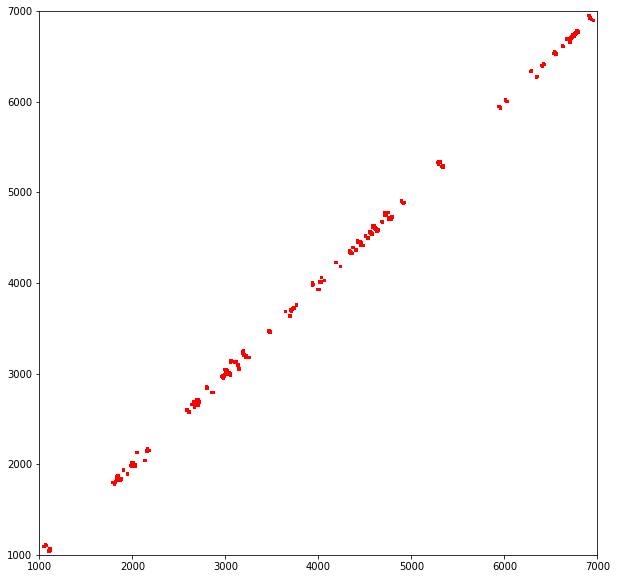

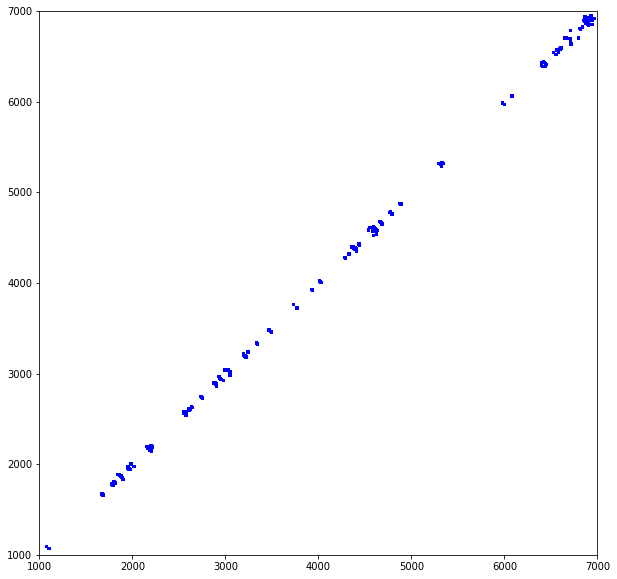

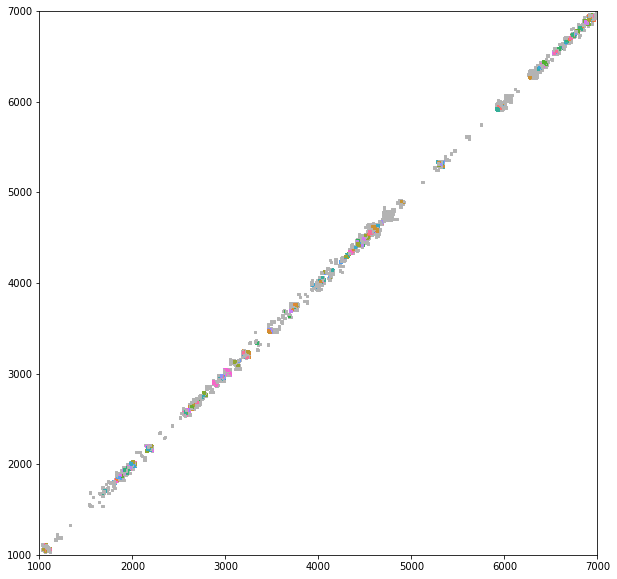

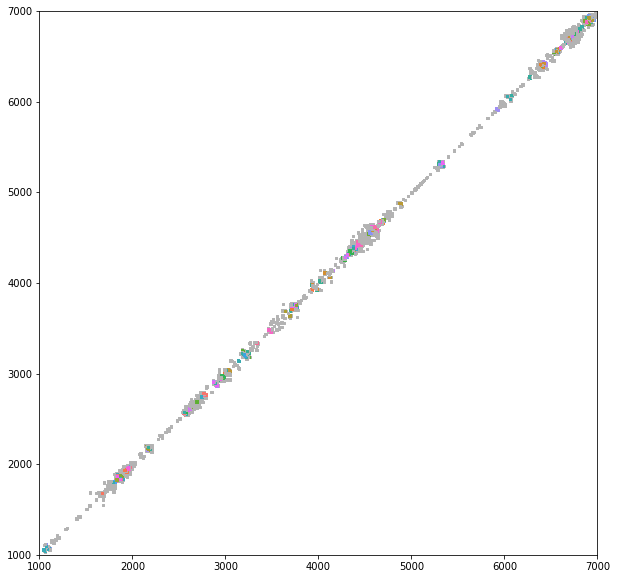

In [278]:
plot_cluster(cd1_positive_cluster, region=[1000, 7000], cluster_color=False, unicolor='red')
plot_cluster(cd2_positive_cluster, region=[1000, 7000], cluster_color=False, unicolor='blue')
plot_cluster(cd1_cluster, region=[1000, 7000], outliers=True)
plot_cluster(cd2_cluster, region=[1000, 7000], outliers=True)
